In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

## Loading Data.

In [4]:
DataFrame =  pd.read_csv('DataSets/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
DataFrame.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [5]:
DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


## Data Cleaning

In [6]:
DataFrame.dropna()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France


In [7]:
DataFrame.drop_duplicates(inplace = True)

## Explorin content of variables

In [8]:
ExploreDF = DataFrame[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
ExploreDF = ExploreDF.reset_index(drop = False)
Countries = ExploreDF['Country'].value_counts()
Countries

Country
United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Singapore                  10
Malta                      10
Unspecified                 8
USA                         7
Iceland                     7
Israel                      6
Canada                      6
Greece                      6
Czech Republic              5
European Community          5
Lithuania                   4
United Arab Emirates        3
Saudi Arabia                2
Ba

In [9]:
Data = dict(type='choropleth',
locations = Countries.index,
locationmode = 'country names', z = Countries,
text = Countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
Heatmap = go.Figure(data = [Data], layout = layout)
iplot(Heatmap, validate=False)

### Customers and products

In [10]:
df = DataFrame.groupby(by= ['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
ProductsPerBasket = df.rename(columns = {'InvoiceDate':'Number of products'})
ProductsPerBasket.sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
...,...,...,...
22177,18283,557956,76
22186,18283,580872,50
22188,18287,570715,38
22187,18287,554065,29


In [11]:
ProductsPerBasket['OrderCanceled'] = ProductsPerBasket['InvoiceNo'].apply(lambda x:int('C' in x))
display(ProductsPerBasket.head())
OrdersCanceled = ProductsPerBasket['OrderCanceled'].sum()
TotalOrders = ProductsPerBasket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(OrdersCanceled, TotalOrders, OrdersCanceled/TotalOrders*100))

,CustomerID,InvoiceNo,Number of products,OrderCanceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


In [12]:
DataFrame.sort_values('CustomerID')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,8/2/2011 8:48,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,1/26/2011 14:30,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,12/7/2010 14:57,1.25,12347,Iceland
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


In [13]:
df_check = DataFrame[DataFrame['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if DataFrame[(DataFrame['CustomerID'] == col[0]) & (DataFrame['Quantity'] == -col[1]) 
                & (DataFrame['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [14]:
df_check = DataFrame[(DataFrame['Quantity'] < 0) & (DataFrame['Description'] != 'Discount')][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if DataFrame[(DataFrame['CustomerID'] == col[0]) & (DataFrame['Quantity'] == -col[1]) 
                & (DataFrame['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [15]:
df_cleaned = DataFrame.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  DataFrame.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = DataFrame[(DataFrame['CustomerID'] == col['CustomerID']) &
                         (DataFrame['StockCode']  == col['StockCode']) & 
                         (DataFrame['InvoiceDate'] < col['InvoiceDate']) & 
                         (DataFrame['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In [16]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 6151
doubtfull_entry: 4322


In [17]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
RemainingEntries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(RemainingEntries.shape[0]))
RemainingEntries

nb of entries to delete: 37


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
27329,C538530,22630,DOLLY GIRL LUNCH BOX,-33,12/13/2010 10:26,1.95,14796,United Kingdom,0
32870,C539195,22942,CHRISTMAS LIGHTS 10 SANTAS,-5,12/16/2010 12:05,8.50,12748,United Kingdom,0
33085,C539221,22941,CHRISTMAS LIGHTS 10 REINDEER,-12,12/16/2010 12:56,8.50,14911,EIRE,0
33086,C539221,22942,CHRISTMAS LIGHTS 10 SANTAS,-10,12/16/2010 12:56,8.50,14911,EIRE,0
77599,C542744,22700,BLACK AND WHITE DOG BOWL,-10,1/31/2011 16:32,0.85,16191,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2/15/2011 11:32,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,3/7/2011 13:49,1.65,14048,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,3/24/2011 14:07,0.66,17754,United Kingdom,0
197417,C553904,22897,OVEN MITT APPLES DESIGN,-11,5/19/2011 18:10,1.45,13081,United Kingdom,0
213271,C555529,22698,PINK REGENCY TEACUP AND SAUCER,-24,6/5/2011 11:45,2.95,16923,United Kingdom,0


### StockCode

In [18]:
Special_Codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
Special_Codes

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0069',
       'DCGSSBOY', 'DCGSSGIRL', 'gift_0001_10', 'S', 'PADS', 'DCGS0004',
       'B'], dtype=object)

In [19]:
for code in Special_Codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
DOT             -> DOTCOM POSTAGE                
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
AMAZONFEE       -> AMAZON FEE                    
DCGS0076        -> SUNJAR LED NIGHT NIGHT LIGHT  
DCGS0003        -> BOXED GLASS ASHTRAY           
gift_0001_40    -> Dotcomgiftshop Gift Voucher £40.00
DCGS0070        -> CAMOUFLAGE DOG COLLAR         
m               -> Manual                        
gift_0001_50    -> Dotcomgiftshop Gift Voucher £50.00
gift_0001_30    -> Dotcomgiftshop Gift Voucher £30.00
gift_0001_20    -> Dotcomgiftshop Gift Voucher £20.00
DCGS0069        -> OOH LA LA DOGS COLLAR         
DCGSSBOY        -> BOYS PARTY BAG                
DCGSSGIRL       -> GIRLS PARTY BAG               
gift_0001_10    -> Dotcomgiftshop Gift Voucher £10.00
S               -> SAMPLES    

### Basket Price

In [20]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom,74215,0.00
72254,542237,22726,ALARM CLOCK BAKELIKE GREEN,4,1/26/2011 14:30,3.75,12347,Iceland,0,15.00
14947,537626,22805,BLUE DRAWER KNOB ACRYLIC EDWARDIAN,12,12/7/2010 14:57,1.25,12347,Iceland,0,15.00
14948,537626,22725,ALARM CLOCK BAKELIKE CHOCOLATE,4,12/7/2010 14:57,3.75,12347,Iceland,0,15.00
14949,537626,22726,ALARM CLOCK BAKELIKE GREEN,4,12/7/2010 14:57,3.75,12347,Iceland,0,15.00
...,...,...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom,0,20.65
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom,0,16.52
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom,0,4.96
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom,0,10.79


In [21]:
# somme des achats / utilisateur & commande
df = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
Basket_Price = df.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# date de la commande
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
df = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].mean()
Basket_Price.loc[:, 'InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
#______________________________________
# selection des entrées significatives:
Basket_Price = Basket_Price[Basket_Price['Basket Price'] > 0]
Basket_Price.sort_values('CustomerID')

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
...,...,...,...,...
18614,18283,557956,192.80,2011-06-23 19:20:00.000000000
18623,18283,580872,208.00,2011-12-06 12:02:00.000000000
18625,18287,570715,1001.32,2011-10-12 10:23:00.000000000
18624,18287,554065,765.28,2011-05-22 10:39:00.000000000


In [22]:
Price_Range = [0, 50, 100, 200, 300, 500, 1000, 5000, 50000]
Number_per_Range = []
for i, price in enumerate(Price_Range):
    if i == 0: continue
    Values = Basket_Price[(Basket_Price['Basket Price'] < price) &
                       (Basket_Price['Basket Price'] > Price_Range[i-1])]['Basket Price'].count()
    Number_per_Range.append(Values)

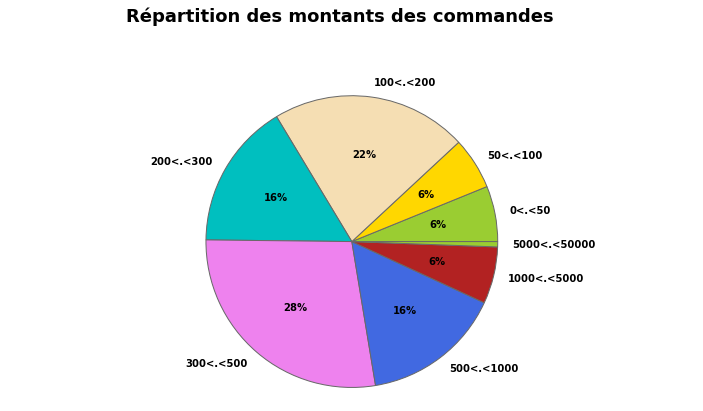

In [23]:
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(Price_Range[i-1], s) for i,s in enumerate(Price_Range) if i != 0]
sizes  = Number_per_Range
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Répartition des montants des commandes", ha='center', fontsize = 18);

In [24]:
Basket_Price = pd.get_dummies(Basket_Price)

In [25]:
from sklearn.preprocessing import StandardScaler
#Scaling
scaler = StandardScaler()
scaler.fit(Basket_Price)
scaled_ds = pd.DataFrame(scaler.transform(Basket_Price),columns= Basket_Price.columns )
print("All features are now scaled")

TypeError: float() argument must be a string or a number, not 'Timestamp'